# EV Charging Simulation
**Discrete Event Simulation of Point-to-Point EV Travel Infrastructure**

**Author**: Jeff Parks<br>
**Course**: CUNY DATA 604 - Simulation & Modeling Techniques (Dr. Larry Fulton)

# Research Question

The primary research question this simulation aims to address is:

"What is the optimal distribution and capacity of public EV charging stations needed to support long-distance travel, reducing consumer 'range anxiety' while minimizing wait times and overall trip time?"

As more consumers switch to EVs, the demand for reliable and efficient charging infrastructure, especially for long-distance travel, has become critical. Ample public EV charging stations are essential for several reasons:

- Range Anxiety Reduction: Adequate charging infrastructure alleviates concerns about running out of power during long trips.
- EV Adoption Acceleration: Robust charging networks encourage more consumers to switch to electric vehicles.
- Economic Impact: Supporting long-distance EV travel can boost tourism and interstate commerce.
- Environmental Benefits: Facilitating EV use for long trips reduces overall carbon emissions from the transportation sector.

# Methodology

The simulation employs a discrete event simulation approach using Python and the SimPy library. Key components include:

- **Stochastic Driver Generation**: Creates a population of EV drivers with varying trip start times and destinations.
- **Charging Network Model**: Simulates a network of charging stations with different capacities and charging speeds.
- **Battery Consumption Model**: Calculates energy consumption based on distance traveled and vehicle efficiency.
- **Charging Process Simulation**: Models queuing, charging times, and battery replenishment at stations.


## Data Sources

Where possible, publicly-available datasets were used to create rough estimates of traffic density, vechicle models, battery capacity and public charging station capacities, including:

- The **Federal Highway Adminstration's TMAS Datasat**<sup>1</sup>, featuring state-level hourly traffic density by day of week. For this project California's 2020 Monday-Friday data were used and fitted to a Gaussian Mixture Distribution to represent their bimodal nature.
- **The Open Charge Map**<sup>2</sup>, with extensive crowd-sourced information on public charging locations and capacities along specific U.S. routes.
- The **Electric Vehicle Database**<sup>3</sup>, with details on specific EV models, ranges and battery capacities.
- **EVadoption**<sup>4</sup> for consumer reports on EV market share by brand and year.


## Additional Considerations

While I tried not to "boil the ocean" on this project, in my enthusiasm I may have inadvertantly warmed up a small body of water to a rather uncomfortable temperature.  Still, this has been an interesting project and a solid introduction to SimPy.  I have tried to apply OOP principles to build in a modular fashion for further development (or raiding elements of it for future simulation projects.)

The repo for this project may be found at https://github.com/jefedigital/sim-ev-chargers. 

# Key Metrics and Variables

The simulation tracks and analyzes several important metrics and variables:

- **Dead Battery Events**: A running count of dead batteries, used for a simple optimization function.
- **Charger Queue and Charing Times**: Average and maximum time drivers spend queuing at charging stations.
- **Charging Station Utilization**: Percentage of time chargers are in use, and noting where bottlenecks or underutilized chargers exist along the point-to-point route.
- **Trip Completion Times**: Including a "Station Time Limit" variable representing consumer elasticity around charger availability, which can be used for route optimization.


Variables that can be adjusted in the simulation include:

- Number and distribution of charging stations
- Number of chargers and their charging speeds per station
- Number of drivers and their consumer preferences represented by Station Time and Trip Time limits.
- EV battery capacities and efficiencies

Several of these variables are fitted to appropriate beta distributions with adjustable parameters, including Number of Stations, Number of Chargers and distribution of Charging Speeds.

# Flowchart

![Flowchart](https://raw.githubusercontent.com/jefedigital/sim-ev-chargers/main/assets/Simulation%20Flowchart.jpg)

# Code

In [1]:
# !pip install matplotlib numpy pandas scipy simpy sk-learn

In [2]:
import simpy 
import random
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.interpolate import make_interp_spline
from sklearn.mixture import GaussianMixture
import warnings

In [3]:
# Constants
LOG_FILE = 'logs/ev_simulation.log'
QA_FOLDER = 'qa/'

# Configure warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in multiply")

# Configure plotting style
plt.style.use('seaborn-v0_8')

In [4]:
# Data

# Vehicle models
VEHICLE_MODELS = {
    1: {
        'Model': 'S',
        'Capacity': 55,
        'Efficiency': 0.17,
        'Share': 0.6
    },
    2: {
        'Model': 'M',
        'Capacity': 75,
        'Efficiency': 0.18,
        'Share': 0.2
    },
    3: {
        'Model': 'L',
        'Capacity': 95,
        'Efficiency': 0.19,
        'Share': 0.15
    },
    4: {
        'Model': 'XL',
        'Capacity': 120,
        'Efficiency': 0.20,
        'Share': 0.5
    }
}

# Chargers per station
CHARGERS_PER_STATION = np.array([4,6,8,10,12,16])

# Charger speeds
CHARGER_SPEEDS = np.array([50,72,150,250])

# Traffic distribution (Gaussian Mixture)
gmm_df = pd.read_csv('https://raw.githubusercontent.com/jefedigital/sim-ev-chargers/main/data/traffic_ca_2020.csv')
GMM = GaussianMixture(n_components=2)
GMM.fit(gmm_df.values)

GaussianMixture(n_components=2)

In [5]:
## Classes: Parameters, Drivers, Stations and Chargers

In [6]:
class SimulationParameters:
  """Default simulation parameters."""
  def __init__(self):
      self.sim_duration = 7 * 24 * 60 
      self.num_epochs = 1
      self.num_drivers = 5
      self.num_stations = 5
      self.num_chargers = 5
      self.loc_destination = 616 # km (SF to LA = 616.2)
      self.avg_speed = 104.585 # km/h (65 mph * 1.609)
      self.station_time_limit = 35 # approx 10% of straight-shot drive time
      self.log_enabled = False
      self.artifacts = False # get data dumps
      self.dist_charger_speed_alpha = 3.5
      self.dist_charger_speed_beta = 2
      self.dist_num_chargers_alpha = 3.5
      self.dist_num_chargers_beta = 2
      self.dist_vehicles_alpha = 3
      self.dist_vehicles_beta = 3.5

  def get_params():
    """Return all parameters as a dictionary."""
    instance = SimulationParameters()
    params = vars(instance)
    for param, value in params.items():
        print(f"{param}: {value}")

In [7]:
class ChargingNetwork:
  """Represents the network of charging stations."""
  instances = []
  def __init__(self, stations):
      self.stations = stations
      ChargingNetwork.instances.append(self)
  
  def get_station(self, station_loc):
    """Get a station at a specific location."""
    for station in self.stations:
      if station.location == station_loc:
        return station
  
  def reserve_charger(self, station, charge_amount):
    """Reserve a charger at a specific station."""
    return station.reserve_charger(charge_amount)
    

In [8]:
class ChargingStation:
  """Represents a charging station."""
  instances = []
  def __init__(self, env, id, location, chargers):
      self.env = env
      self.id = id
      self.location = location
      self.chargers = chargers
      self.visits = 0
      self.charge_time = 0
      self.queue_time = 0
      ChargingStation.instances.append(self)

  def get_earliest_charger(self):
    """Get the charger that will be available the earliest."""
    return sorted(self.chargers, key=lambda c: (-c.charging_speed, c.release_time))[0]
   
  def reserve_charger(self, charge_amount):
    """Reserve a charger and update its release time."""
    charger = self.get_earliest_charger()
    charge_time = charge_amount / charger.charging_speed * 60 # minutes
    charger.update_release_time(charge_time) 
    return charger.request()

  def delete_all():
    """Delete all instances of ChargingStation."""
    while ChargingStation.instances:
        instance = ChargingStation.instances.pop()
        del instance

In [9]:
class Charger(simpy.Resource):
  """Represents a charger at a charging station."""
  instances = []
  def __init__(self, env, id, charging_speed, release_time):
    super().__init__(env, capacity=1)
    self.id = id
    self.charging_speed = charging_speed
    self.release_time = release_time
    Charger.instances.append(self)

  def update_release_time(self, charging_time):
    """Update the release time of the charger."""
    self.release_time = max(self.release_time, self._env.now) + charging_time

In [10]:
class Driver:
  """Represents a driver in the simulation."""
  instances = []

  def __init__(self, env, id, station_list, charging_network, avg_speed, loc_destination, model, battery_capacity, efficiency, battery_level):
      self.env = env
      self.id = id
      self.station_list = station_list
      self.charging_network = charging_network
      self.avg_speed = avg_speed
      self.loc_destination = loc_destination
      self.model = model
      self.battery_capacity = battery_capacity # kWh
      self.efficiency = efficiency # kWh/km
      self.battery_level = battery_level # kWh
      self.avg_rate = self.avg_speed/60  # km/m
      self.loc_current = 0
      self.mileage = 0
      self.queue_time = 0
      self.charge_time = 0
      self.station_time = 0
      self.charges = 0
      self.trip_start_time = 0
      self.trip_end_time = 0
      self.trip_time = 0
      self.db = 0
      self.num_stations = 0
      Driver.instances.append(self)
     
  def drive_cycle(self):
    """Simulate the driving cycle of the driver."""
    # trip start vars
    self.trip_start_time = generate_trip_start_times(GMM,1)[0] * 60

    yield self.env.timeout(self.trip_start_time)
    driver_log_msg(self, (f"Started trip in {self.model} with {self.battery_capacity} kWh battery"))
    
    stations_arr = np.array(self.station_list)
    self.num_stations = len(stations_arr) # for params sweep tracking

    while self.loc_current < self.loc_destination:

        # max distance on current battery level
        drive_distance_max = self.battery_level / self.efficiency
        
        # if final destination reachable, go there
        if self.loc_destination < self.loc_current + drive_distance_max:
            dest = self.loc_destination 
            station = None
        else:
            # if not, find next best station
            station_dist_arr = self.loc_current + drive_distance_max - stations_arr
            station_dist_arr[stations_arr < self.loc_current] = np.inf # only ahead of current position
            station_dist_arr[station_dist_arr < 0] = np.inf # only reachable on current battery level
            dest = stations_arr[np.argmin(station_dist_arr)] # furthest reachable station

            if dest > 0:
                station = self.charging_network.get_station(dest)
            else:
                # if no station reachable, go max distance and trigger 'dead battery' error
                dest = drive_distance_max 
                station = None

        # drive  
        drive_distance = dest - self.loc_current
        drive_time = abs(drive_distance) / self.avg_speed * 60 # minutes
        
        yield self.env.timeout(drive_time) # driving time
        
        self.trip_time += drive_time # adjust trip time
        self.loc_current += drive_distance # adjust location
        self.mileage += abs(drive_distance) # add mileage
        self.battery_level -= abs(drive_distance) * self.efficiency # adjust battery level
        driver_log_msg(self, "completed leg")

        if station:
            # reserve available charger
            charge_amount = self.battery_capacity - self.battery_level
            charger_request = self.charging_network.reserve_charger(station, charge_amount)

            driver_log_msg(self, f"started queue for charger")
            queue_start = self.env.now

            with charger_request as req:

                yield req 
                charger = req.resource
                self.charges += 1
                station.visits += 1
                self.battery_level = self.battery_capacity # 100% charge
              
                charge_time = charge_amount / charger.charging_speed * 60 # in minutes
                self.charge_time += charge_time
                self.station_time += charge_time
                self.trip_time += charge_time
                station.charge_time += charge_time

                queue_time = (self.env.now - queue_start) if (self.env.now - queue_start > charge_time) else 0
                self.queue_time += queue_time
                self.station_time += queue_time
                self.trip_time += queue_time
                station.queue_time += queue_time

                yield self.env.timeout(charge_time)                    
                driver_log_msg(self, f"used charger {charger.id} @ {charger.charging_speed} kwH at station {station.id}")

        elif self.battery_level <= 0:
            self.battery_level = 0
            raise DeadBatteryError(f"Driver {self.id} has a dead battery at location {self.loc_current}")
        
    driver_log_msg(self, "completed trip")

    # trip end metrics
    self.trip_end_time = self.env.now
    self.battery_level_end = self.battery_level

  def run(self):
    """Run the driver's trip."""
    try:
        yield self.env.process(self.drive_cycle())
    except DeadBatteryError as e:
            log_msg(self.env, f"Error: {e}", level=logging.WARNING)
            self.db = 1

  def delete_all():
    """Delete all instances of Driver."""
    while Driver.instances:
        instance = Driver.instances.pop()
        del instance

In [11]:
## Simulation Functions

In [12]:
def run_simulation(params, sweep = False, **kwargs):
  """Run the main simulation"""
  setup_logging(params)
  driver_results_df = pd.DataFrame()
  station_results_df = pd.DataFrame()

  # override any params
  for key, value in kwargs.items(): 
        setattr(params, key, value)
    
  logging.getLogger('EVSimulation').log(level=logging.INFO, msg='## run starting ##')

  try:
    for epoch in range(params.num_epochs):
        
      env = simpy.Environment()
      run_simulation_epoch(env, params)
      env.run(until=params.sim_duration)
  
      driver_epoch_df = get_driver_results(params)
      driver_epoch_df['epoch'] = epoch+1
      driver_results_df = pd.concat([driver_results_df, driver_epoch_df])
      Driver.delete_all()
  
      station_epoch_df = get_station_results(params)
      station_epoch_df['epoch'] = epoch+1
      station_results_df = pd.concat([station_results_df, station_epoch_df])
      ChargingStation.delete_all()
  
    driver_metrics_dict = get_driver_metrics(driver_results_df)
    station_metrics_df = get_station_metrics(station_results_df)
                                         
    logging.getLogger('EVSimulation').log(level=logging.INFO, msg='## run complete ##\n\n')
                                         
    return {'driver_results': driver_results_df, 
            'driver_metrics': driver_metrics_dict,
            'station_results': station_results_df,
            'station_metrics': station_metrics_df
          }
  except Exception as e:
        logging.getLogger('EVSimulation').error(f"Error in simulation: {str(e)}")
        raise

In [13]:
def run_simulation_epoch(env, params):
  """Run a single epoch of the simulation."""
  
  log_msg(env, '### epoch starting ###')
  log_msg(env, f"Began simulation with parameters - drivers: {params.num_drivers}, stations: {params.num_stations}, destination: {params.loc_destination}, speed: {params.avg_speed}, charger speed params: {params.dist_charger_speed_alpha},{params.dist_charger_speed_beta}, num chargers params: {params.dist_num_chargers_alpha},{params.dist_num_chargers_beta}")
  
  # initialize charging station network
  stations = [ChargingStation(env, 
                              id = n+1, 
                              location = np.round(np.linspace(0,params.loc_destination,params.num_stations+2),0)[n],
                              chargers=[Charger(env, 
                                                id = i+1, 
                                                charging_speed=generate_discrete_beta_samples(CHARGER_SPEEDS,1,
                                                                                              a=params.dist_charger_speed_alpha,
                                                                                              b=params.dist_charger_speed_beta)[0], 
                                                release_time = i) 
                                        for i in range(generate_discrete_beta_samples(CHARGERS_PER_STATION,1,
                                                                                      a=params.dist_num_chargers_alpha,
                                                                                      b=params.dist_num_chargers_alpha)[0])
                                       ]) 
                                    for n in range(params.num_stations+2)]

  station_list = sorted([station.location for station in stations])
  log_msg(env, f"Stations at {station_list}")
   
  charging_network = ChargingNetwork(stations)
  
  # initialize drivers and start their trips
  for id in range(params.num_drivers):
      model, battery_capacity, efficiency, battery_level = generate_vehicle(params)
    
      driver = Driver(env, id+1, station_list, charging_network, params.avg_speed, params.loc_destination, model, battery_capacity, efficiency, battery_level)
 
      env.process(driver.run())

In [142]:
def run_simulation_montecarlo(params, num_runs):
  """Run a parameter sweep simulation."""
  driver_results_df = pd.DataFrame()
  station_results_df = pd.DataFrame()

  try:
       
    for i in range(num_runs):

      # randomize selected params
      params.num_drivers = random.randint(100,2500)
      params.num_stations = random.randint(5,500)
      params.dist_charger_speed_alpha = random.uniform(2,4)
      params.dist_num_chargers_alpha = random.uniform(2,4)
      params.dist_vehicles_beta = random.uniform(2.5,3.5)

      if params.log_enabled == True:
        print(f'Monte Carlo {i+1} | Drivers {params.num_drivers}, Stations {params.num_stations}, Num Chargers a {params.dist_num_chargers_alpha}, Charger Speed a {params.dist_charger_speed_alpha}, Vehicles b {params.dist_vehicles_beta}') 

      # run sim and epochs
      results_dict = run_simulation(params)

      # concat results
      driver_df = results_dict['driver_results']
      driver_df['mc_run'] = i+1
      
      station_df = results_dict['station_results']
      station_df['mc_run'] = i+1
      
      driver_results_df = pd.concat([driver_results_df, driver_df])
      station_results_df = pd.concat([station_results_df, station_df])

  except Exception as e:
    logging.getLogger('EVSimulation').error(f"Error in simulation: {str(e)}")
    raise
    
  # qa
  driver_results_df.to_csv('qa/montecarlo_driver_results.csv', index=False) if params.artifacts else None # save for qa
  station_results_df.to_csv('qa/montecarlo_station_results.csv', index=False) if params.artifacts else None # save for qa

  return {'driver_results': driver_results_df, 
          'station_results': station_results_df}

In [130]:
def run_simulation_sweep(params, sweep_variable):
  """Run a parameter sweep simulation."""
  sweep_results_df = pd.DataFrame()

  try:
    
    if sweep_variable == 'num_stations':

      print(f'(num_stations will sweep from 1-100)')
      
      for num_stations in range(1, 101):
        params.num_stations = num_stations
        results_dict = run_simulation(params, sweep = True)
        sweep_results_df = pd.concat([sweep_results_df, results_dict['driver_results']])

      # constraints: no dead batteries, mean station_time under limit, minimum num_stations
      filter_results_df = sweep_results_df.groupby('num_stations').filter(
          lambda x: x['db'].sum() == 0 and x['station_time'].mean() <= params.station_time_limit)
      min_num_stations = filter_results_df['num_stations'].min()
      min_sweep_results_df = filter_results_df[filter_results_df['num_stations'] == min_num_stations]
    
      # return optimal params
      sweep_params = params
      setattr(sweep_params, 'num_stations', min_num_stations)

    ## elif:

  except Exception as e:
    logging.getLogger('EVSimulation').error(f"Error in simulation: {str(e)}")
    raise
    
  # qa
  sweep_results_df.to_csv('qa/sweep_results_df.csv', index=False) if params.artifacts else None
  min_sweep_results_df.to_csv('qa/min_sweep_results.csv', index=False) if params.artifacts else None

  0 if np.isnan(min_num_stations) else min_num_stations
  
  return {'min_num_stations': min_num_stations, 
          'sweep_results': sweep_results_df,
          'sweep_params': sweep_params}

In [16]:
def generate_vehicle(params):
  data = list(VEHICLE_MODELS.keys())
  vehicle_key = generate_discrete_beta_samples(data,1,
                                               a=params.dist_vehicles_alpha,
                                               b=params.dist_vehicles_beta)[0]
  vehicle = VEHICLE_MODELS[vehicle_key]

  model = vehicle['Model']
  battery_capacity = vehicle['Capacity']
  efficiency = vehicle['Efficiency']
  battery_level = round(random.uniform(0.6, 1) * battery_capacity,1) # random starting charge level 60-100%
  return(model, battery_capacity, efficiency, battery_level)

In [17]:
def generate_trip_start_times(gmm, num_trips=1, min_value=0, max_value=24):
    """Generate trip start times from fitted GMM, rejection sampling for valid hours."""
    # orig wrote to handle all samples at once, too computationally expensive
    sample_arr = np.array([])
    
    for i in range(num_trips):
        good_sample = False

        while not good_sample:
            # sample from the new instance
            samples, _ = gmm.sample(1)
            samples = [s[0] for s in samples] # samples only, not the probabilities

            # check if the samples are within the desired range
            good_sample = all([min_value <= s < max_value for s in samples])

        sample_arr = np.append(sample_arr, samples)

    return sample_arr.tolist()

In [18]:
def generate_discrete_beta_samples(data, num_samples=1, a=3, b=3):

  # get samples from beta dist
  samples = stats.beta.rvs(a, b, size=num_samples)
  
  # category breakpoints for beta dist interval [0,1]
  breaks = [b + 1/len(data) for b in np.arange(0,1,1/len(data))]
  
  # categorize
  samples_cat = [next(i for i, val in enumerate(breaks) if sample <= val) for sample in samples]
  
  # map to data values
  samples_map = [data[c] for c in samples_cat]

  return samples_map

In [19]:
## Calc Functions

In [20]:
def get_driver_results(params):
  """Get the results for all drivers in the simulation."""
  data = {
      'num_stations': [], 
      'driver_id': [],
      'model': [],
      'battery_capacity': [],
      'efficiency': [],
      'battery_level_end': [],
      'mileage': [],
      'trip_start_time': [],
      'trip_end_time': [],
      'trip_time': [],
      'queue_time': [],
      'charge_time': [],
      'station_time': [],
      'charges': [],
      'db': []
  }
  for driver in Driver.instances:
      data['num_stations'].append(driver.num_stations)
      data['driver_id'].append(driver.id)
      data['model'].append(driver.model)
      data['battery_capacity'].append(driver.battery_capacity)
      data['efficiency'].append(driver.efficiency)
      data['battery_level_end'].append(driver.battery_level)
      data['trip_start_time'].append(driver.trip_start_time)
      data['trip_end_time'].append(driver.trip_end_time)
      data['trip_time'].append(driver.trip_time)
      data['mileage'].append(driver.mileage)
      data['queue_time'].append(driver.queue_time)
      data['charge_time'].append(driver.charge_time)
      data['station_time'].append(driver.station_time)
      data['charges'].append(driver.charges)
      data['db'].append(driver.db)

  df = pd.DataFrame(data)
  df.to_csv('qa/driver_results.csv', index=False) if params.artifacts else None # save for qa
  return df

In [21]:
def get_driver_metrics(df):
  """Calculate metrics from driver results."""
  avg_mileage = df['mileage'].mean()
  
  avg_trip_time = df['trip_time'].mean()
  ci_trip_time = stats.t.interval(0.95, len(df)-1, avg_trip_time, stats.sem(df['trip_time']))
  std_trip_time = df['trip_time'].std()
  max_trip_time = df['trip_time'].max()
  
  avg_queue_time = df['queue_time'].mean()
  ci_queue_time = stats.t.interval(0.95, len(df)-1, avg_queue_time, stats.sem(df['queue_time']))
  std_queue_time = df['queue_time'].std()
  max_queue_time = df['queue_time'].max()

  avg_charging_time = df['charge_time'].mean()
  ci_charging_time = stats.t.interval(0.95, len(df)-1, avg_charging_time, stats.sem(df['charge_time']))
  std_charging_time = df['charge_time'].std()
  max_charging_time = df['charge_time'].max()
 
  avg_station_time = df['station_time'].mean()
  ci_station_time = stats.t.interval(0.95, len(df)-1, avg_station_time, stats.sem(df['station_time']))
  std_station_time = df['station_time'].std()
  max_station_time = df['station_time'].max()
 
  avg_dead_batteries =  df['db'].mean()

  dict = {
      'avg_mileage': avg_mileage,
   
      'avg_trip_time': avg_trip_time,
      'ci_trip_time': ci_trip_time,
      'std_trip_time': std_trip_time,
      'max_trip_time': max_trip_time,
    
      'avg_queue_time': avg_queue_time,
      'ci_queue_time': ci_queue_time,
      'std_queue_time': std_queue_time,
      'max_queue_time': max_queue_time,
    
      'avg_charging_time': avg_charging_time,
      'ci_charging_time': ci_charging_time,
      'std_charging_time': std_charging_time,
      'max_charging_time': max_charging_time,
    
      'avg_station_time': avg_station_time,
      'ci_station_time': ci_station_time,
      'std_station_time': std_station_time,
      'max_station_time': max_station_time,
    
      'avg_dead_batteries': avg_dead_batteries
  }

  dict_rounded = {k: (tuple(round(v,1) for v in value) if isinstance(value, tuple) else round(value,1)) for k, value in dict.items()}
  return dict_rounded

In [22]:
def get_station_results(params):
  """Get the results for all charging stations in the simulation."""
  data = {
      'station_id': [],
      'location': [],
      'visits': [],
      'charge_time': [],
      'queue_time': [],
      'num_chargers': [],
      'charger_speeds': []
  }

  for station in ChargingStation.instances:
    num_chargers = 0
    charger_speeds = []

    for charger in station.chargers:
      num_chargers +=1
      charger_speeds.append(charger.charging_speed)

    data['station_id'].append(station.id)
    data['location'].append(station.location)
    data['visits'].append(station.visits)
    data['charge_time'].append(station.charge_time)
    data['queue_time'].append(station.queue_time)
    data['num_chargers'].append(num_chargers - 2) # less the start/end points
    data['charger_speeds'].append(charger_speeds) # a list

  df = pd.DataFrame(data)
  df.to_csv('qa/station_results.csv', index=False) if params.artifacts else None # save for qa
  return df

In [23]:
def get_station_metrics(df):
  """Calculate metrics from station results."""
  df = df.groupby('station_id')[['visits','charge_time','queue_time']].mean()
  df['total_time'] = df['charge_time'] + df['queue_time']
  df['avg_time'] = df['total_time'] / df['visits']
  df['avg_queue_time'] = df['queue_time'] / df['visits']
  df['avg_charge_time'] = df['charge_time'] / df['visits']
  return df

In [24]:
## Graphing Functions

In [86]:
def get_driver_results_hist(df):
  """Generate hists for driver results."""
  fig, axs = plt.subplots(1,6,figsize=(12, 3))

  # Plot the histograms
  axs[0].hist(df['battery_capacity'], bins=30, color='grey')
  axs[0].set_title('Battery Capacity')

  axs[1].hist(df['trip_start_time'], bins=30, color='grey')
  axs[1].set_title('Trip Start Time')

  axs[2].hist(df['trip_end_time'], bins=30, color='grey')
  axs[2].set_title('Trip End Time')
 
  axs[3].hist(df['queue_time'], bins=30, color='grey')
  axs[3].set_title('Total Queue Time')
  
  axs[4].hist(df['charge_time'], bins=30, color='grey')
  axs[4].set_title('Total Charge Time')

  axs[5].hist(df['trip_time'], bins=30, color='grey')
  axs[5].set_title('Total Trip Time')

  plt.close(fig)
  return fig

In [92]:
def get_station_metrics_plot(df):
  """Generate a plot for station metrics."""
  fig, ax = plt.subplots(figsize=(12, 5))
  ax2 = ax.twinx()
  
  df['visits'].plot(kind='bar', color='grey', ax=ax, position=1)
  df['avg_queue_time'].plot(kind='bar', color='pink', ax=ax2)
  df['avg_charge_time'].plot(kind='bar', color='lightgreen', ax=ax2, bottom=df['avg_queue_time'])

  ax.set_ylabel('Total Visits')
  ax.legend(['Total Visits'], loc='upper left', bbox_to_anchor=(0, 0.9))
  
  ax2.set_title('Average Queue & Charge Time by Station')
  ax2.set_xlabel('Station ID')
  ax2.set_ylabel('Time')
  ax2.legend(['Avg Queue Time', 'Avg Charge Time'], loc='upper left')
  
  ax2.grid(False)

  plt.close(fig)
  return fig

In [98]:
def get_station_metrics_hist(df):
  """Generate hists for station results."""
  fig, axs = plt.subplots(1,2,figsize=(6,3))

  all_charger_speeds = [item for sublist in df['charger_speeds'] for item in sublist]
  
  # Plot the histograms
  axs[0].hist(df['num_chargers'], bins=30, color='grey')
  axs[0].set_title('Chargers per Station')

  axs[1].hist(all_charger_speeds, bins=30, color='grey')
  axs[1].set_title('Charger Speeds')

  plt.close(fig)
  return fig

In [28]:
def get_sweep_graphs_plot(df,ax,min_num_stations,xcol,ycol,xlab,ylab,title):
  """Generate a single sweep graph plot."""
  s = df.groupby(xcol)[ycol].mean().reset_index()
  s.columns = ['x','y']
  
  x = s['x']
  y = s['y']
  x_smooth = np.linspace(x.min(), x.max(), 300)
  spl = make_interp_spline(x, y, k=3)
  y_smooth = spl(x_smooth)

  ax.plot(x_smooth, y_smooth)
  ax.scatter(x, y, color='red')  # Optional: also plot the original points
  ax.axvline(x=min_num_stations, color='green', linestyle='--')
  ax.set_title(title)
  # ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.grid(True)

In [93]:
def get_sweep_plots_grid(df,min_num_stations):
  """Generate a grid of sweep plots."""
  fig, axs = plt.subplots(2, 2, figsize=(12, 8))
  get_sweep_graphs_plot(df, axs[0,0], min_num_stations, 'num_stations','trip_time','Num Stations','Mean Trip Time','Mean Trip Times by Num Stations')
  get_sweep_graphs_plot(df, axs[0,1], min_num_stations, 'num_stations','queue_time','Num Stations','Mean Queue Time','Mean Queue Times by Num Stations')
  get_sweep_graphs_plot(df, axs[1,0], min_num_stations, 'num_stations','charge_time','Num Stations','Mean Charge Time','Mean Charge Times by Num Stations')
  get_sweep_graphs_plot(df, axs[1,1], min_num_stations, 'num_stations','db','Num Stations','Dead Battery Pct','Dead Batteries by Num Stations')
  plt.close(fig)
  return fig

In [30]:
## Errors and Logging

In [31]:
class DeadBatteryError(Exception):
    "Raised when the battery level <= 0"
    pass

def setup_logging(params):
    level = logging.INFO if params.log_enabled == True else logging.CRITICAL
    logging.basicConfig(
        filename = 'logs/ev_simulation.log',
        filemode='w', # overwrite log file
        level=level,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )

def driver_log_msg(driver, message):
    status = "Driver %s [Loc: %.1f Mlg: %.1f Bat: %.1f QueT: %.1f ChgT: %.1f StaT: %.1f TrpT: %.1f] - %s" % (driver.id, driver.loc_current, driver.mileage, driver.battery_level, driver.queue_time, driver.charge_time, driver.station_time, driver.trip_time, message)
    log_msg(driver.env, status)


def log_msg(env, message, level=logging.INFO):
    timestamp = round(env.now, 1)
    logger = logging.getLogger('EVSimulation')
    logger.log(level, f"[{timestamp}] {message}")

In [32]:
## User Functions - use these to run simulations

In [77]:
def run_scenario(**kwargs):
  """Run a single simulation scenario."""
  if 'params' in kwargs:
    params = kwargs['params'] # take a full params object (like sweep_params)
  else:
    params = SimulationParameters()
    # overrride any params
    for key, value in kwargs.items(): 
        setattr(params, key, value)

  if params.log_enabled:
    print('Running scenario with these parameters:')
    for param, value in vars(params).items():
        print(f"{param}: {value}")

  results_dict = run_simulation(params)
  
  results_dict['driver_results_hist'] = get_driver_results_hist(results_dict['driver_results'])
  results_dict['station_metrics_plot'] = get_station_metrics_plot(results_dict['station_metrics'])
  results_dict['station_metrics_hist'] = get_station_metrics_hist(results_dict['station_results'])
  
  return results_dict

In [78]:
def run_sweep(sweep_variable, **kwargs):
  """Run a parameter sweep simulation."""
  params = SimulationParameters()

  # overrride any params
  for key, value in kwargs.items():
        setattr(params, key, value)

  if params.log_enabled:
    print('Running sweep with these parameters:')
    for param, value in vars(params).items():
        print(f"{param}: {value}")

  results_dict = run_simulation_sweep(params, sweep_variable)
  results_dict['sweep_plots'] = get_sweep_plots_grid(results_dict['sweep_results'], results_dict['min_num_stations'])
  
  return results_dict

In [140]:
def run_montecarlo(num_runs, **kwargs):
  """Run a monte carlo simulation."""
  params = SimulationParameters() # load defaults

  # overrride any params
  for key, value in kwargs.items():
        setattr(params, key, value)

  results_dict = run_simulation_montecarlo(params, num_runs)
  
  results_dict['driver_results_hist'] = get_driver_results_hist(results_dict['driver_results'])
  results_dict['station_metrics_hist'] = get_station_metrics_hist(results_dict['station_results'])
  
  return results_dict

In [ ]:
## End Code

# Analysis
For the following exercises, we will consider scenarios of one-way weekday trips between San Francisco and Los Angeles, CA.  The estimated highway driving distance of this route is appoximately 616km, and could theoretically be travelled in about 5.8 hours (or 350 minutes) at an average speed of 65 hm/h.

**Scenario A**: Long Queue Times<br>
For the first scenario, we'll simulate 1000 drivers on the road with access to 25 charging stations disributed evenly, with their trip start times staggered to match out GMM of actual traffic density from the National Highway Adminsistration.  

In [99]:
s1 = run_scenario(num_drivers=1000, num_stations=25, num_epochs=20)

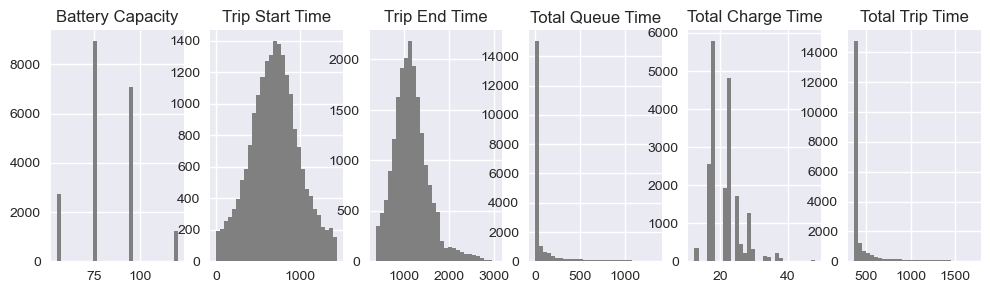

In [96]:
s1['driver_results_hist']

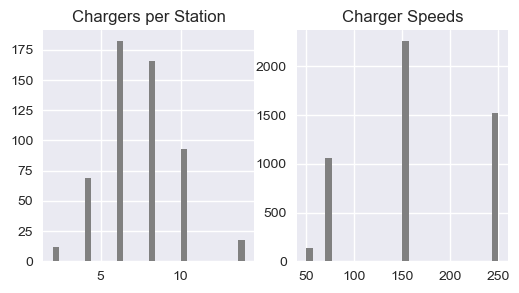

In [100]:
s1['station_metrics_hist']

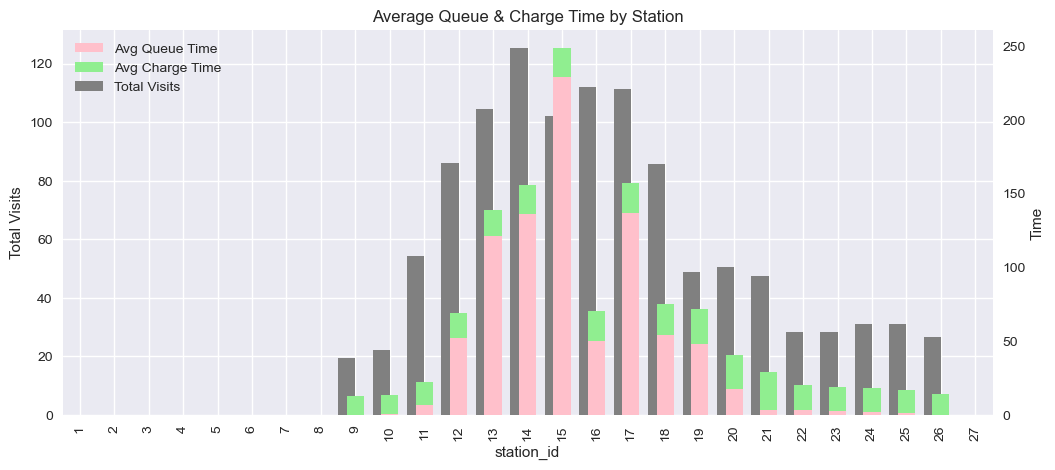

In [101]:
s1['station_metrics_plot']

In [105]:
s1['driver_metrics']

{'avg_mileage': 616.0,
 'avg_trip_time': 461.9,
 'ci_trip_time': (459.0, 464.9),
 'std_trip_time': 215.1,
 'max_trip_time': 1810.1,
 'avg_queue_time': 87.3,
 'ci_queue_time': (84.3, 90.3),
 'std_queue_time': 215.7,
 'max_queue_time': 1440.2,
 'avg_charging_time': 21.3,
 'ci_charging_time': (21.2, 21.3),
 'std_charging_time': 4.6,
 'max_charging_time': 48.0,
 'avg_station_time': 108.5,
 'ci_station_time': (105.6, 111.5),
 'std_station_time': 215.1,
 'max_station_time': 1456.7,
 'avg_dead_batteries': 0.0}

At first glance this seems like a pretty good solution - no dead batteries and stranded motorists on the highway!  But if we look closely at the Average Trip Time and the especially the red bars representing Queue Time on the station plot, we may have a lot of drivers waiting in line for chargers.  Not a great customer experience, especially at those midpoint stations where rider are waiting over an hour for a 20-minute charge.  

**Scenario 3**: More Stations, Less Waiting?<br>
Let's see if we can do better by making some heavier infrastructure investments and doubling the number of stations along this route:

In [107]:
s2 = run_scenario(num_drivers=1000, num_stations=50, num_epochs=20)

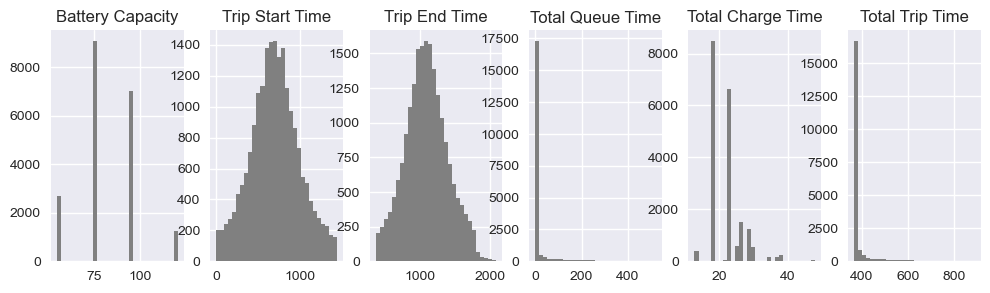

In [108]:
s2['driver_results_hist']

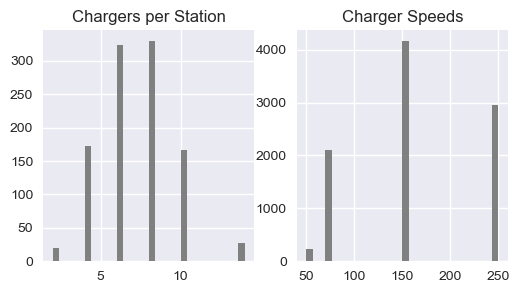

In [109]:
s2['station_metrics_hist']

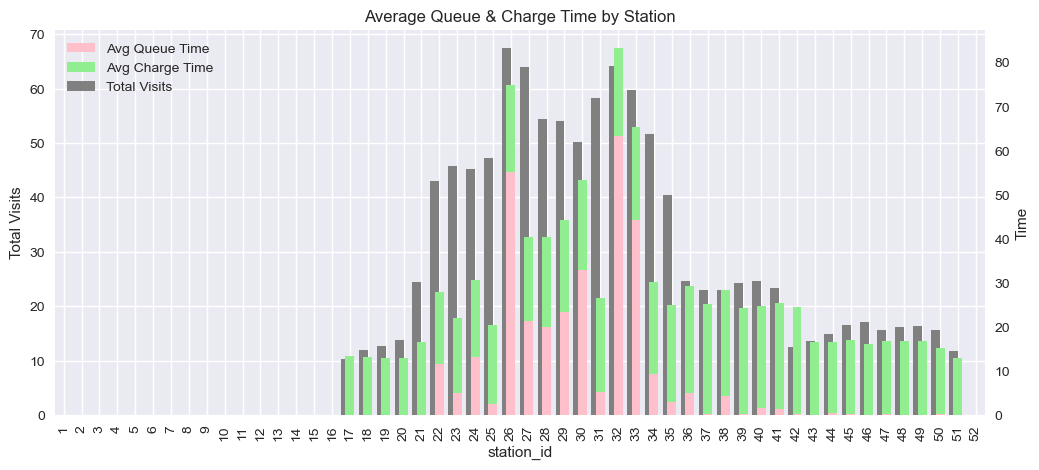

In [110]:
s2['station_metrics_plot']

In [111]:
s1['driver_metrics']

{'avg_mileage': 616.0,
 'avg_trip_time': 393.0,
 'ci_trip_time': (392.1, 393.9),
 'std_trip_time': 67.1,
 'max_trip_time': 1249.9,
 'avg_queue_time': 18.1,
 'ci_queue_time': (17.2, 19.0),
 'std_queue_time': 67.0,
 'max_queue_time': 858.5,
 'avg_charging_time': 21.5,
 'ci_charging_time': (21.5, 21.6),
 'std_charging_time': 4.7,
 'max_charging_time': 48.0,
 'avg_station_time': 39.6,
 'ci_station_time': (38.7, 40.5),
 'std_station_time': 67.1,
 'max_station_time': 896.5,
 'avg_dead_batteries': 0.0}

This second scenario is looking much better with average Queue Time greatly reduced!  However we might note there are still some long wait times around those midpoint stations - perhaps this might suggest more geographically-targeted infrastructure build along heavily-trafficked routes.  Since this simulation spreads the stations out uniformly we won't be able to tackle that question today, however.

**Scenario 3: Optimize Total Trip Time**<br>
However we may be able to identify an ideal station frequency for the current simulation model, based on consumer preferences for total trip time.  Assuming the average consumer doesn't want to spend more than 30-35 minutes charging on a nearly 6-hour trip, we can perform a simple sensitivity analysis and sweep a range of viable station counts, selecting the minumum number of stations that produce no 'dead battery' events and get us to our destination in 385 minutes or less (on average.)

In [131]:
s3= run_sweep(sweep_variable = 'num_stations', num_drivers=1000, station_time_limit=35, num_epochs=10, artifacts=True)

(num_stations will sweep from 1-100)


In [132]:
s3['min_num_stations']

47

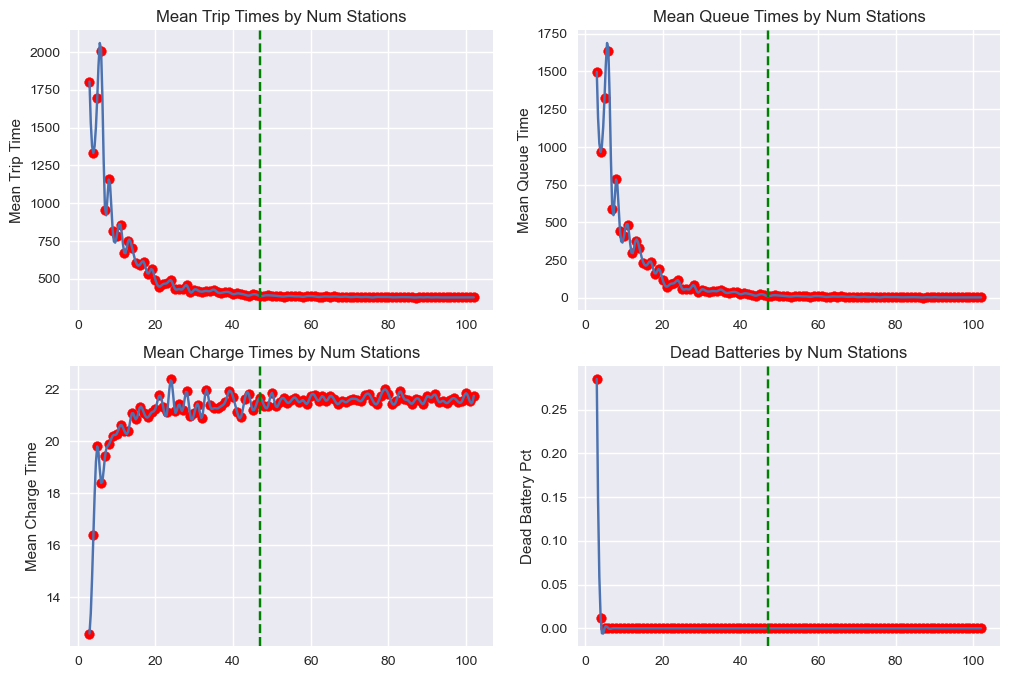

In [133]:
s3['sweep_plots']

Your mileage may vary (sorry) but we should be seeing ~48 stations for an optimum.  Let's run this scenario to obtain our metrics:

In [135]:
s3b = run_scenario(num_drivers=1000, num_stations=48, num_epochs=35)

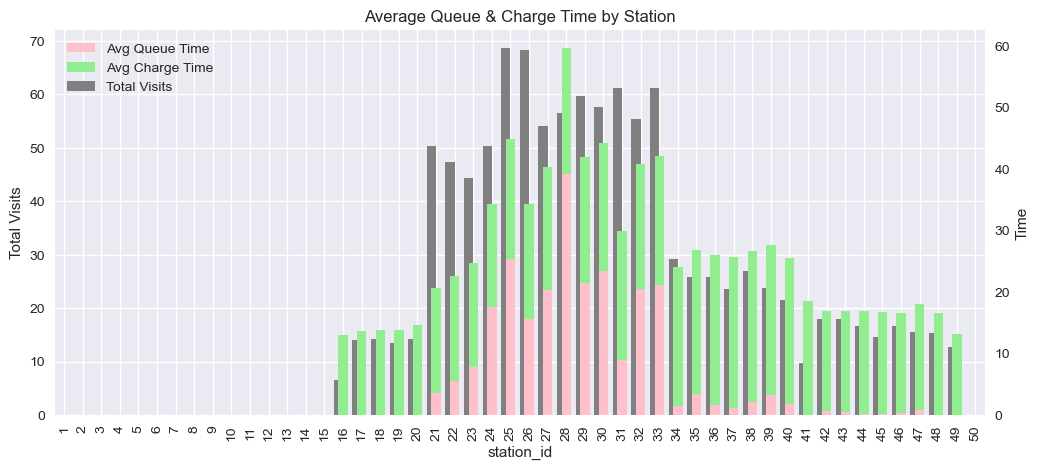

In [136]:
s3b['station_metrics_plot']

In [138]:
s3b['driver_metrics']

{'avg_mileage': 616.0,
 'avg_trip_time': 388.8,
 'ci_trip_time': (388.3, 389.3),
 'std_trip_time': 51.5,
 'max_trip_time': 927.9,
 'avg_queue_time': 13.8,
 'ci_queue_time': (13.3, 14.4),
 'std_queue_time': 51.7,
 'max_queue_time': 556.5,
 'avg_charging_time': 21.6,
 'ci_charging_time': (21.5, 21.6),
 'std_charging_time': 4.8,
 'max_charging_time': 48.0,
 'avg_station_time': 35.4,
 'ci_station_time': (34.9, 35.9),
 'std_station_time': 51.5,
 'max_station_time': 574.5,
 'avg_dead_batteries': 0.0}

We're seeing better results here, with an average trip time much more in line with consumer preferences.  Average queue time has come down significantly, though stations in the 21-33km range are still producting lines.  As mentioned previously, it would be interesting to simulate the expected impact of increased charging capacity at these statiions.

**Scenario 4: Monte Carlo**<br>
Finally, we can begin to explore some of the relationships between our simulation variables by performing a Monte Carlo simulation, randomly varying our parameters:

In [143]:
s4 = run_montecarlo(num_runs=50, num_epochs=5)

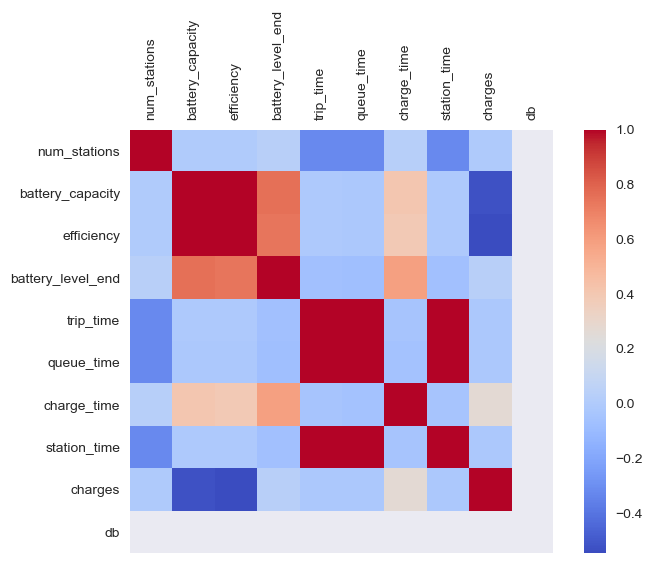

In [153]:
df = s4['driver_results']
corr = df.drop(columns=['driver_id','mileage','model','trip_start_time','trip_end_time','epoch','mc_run']).corr()

fig, ax = plt.subplots()
cax = ax.matshow(corr, cmap='coolwarm')

# Add color bar
plt.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)
ax.grid(visible=False, which='major')

# Rotate the x labels for better readability
plt.xticks(rotation=90)

plt.show()

While simply a first pass at a Monte Carlo analysis, we can confirm some of the observed characteristics of our simulation, and perhaps uncover some new ones. For example, the relationship between trip time <> queue time is stronger than trip time <> charge time, reinforcing our finding that queue times are a serious bottleneck for our simulation!

# Conclusions

Of course this is only half the story for our simple model of point-to-point travel between two major cities -- there is also traffic moving in the opposite direction, perhaps experiencing similar charger queue woes in the reverse order.  However we can make a few observations based on this example:

- Assuming stations are roughly equally spaced along this 600km route, approximately 1 station for every 20 drivers is a starting benchmark for station density supporting long-distance travel, statistically reducing or eliminating 'dead battery' events due to charger scarcity.
  
- This station density can be further optimized by analyzing locations experiencing long charging queues, and simulating increased station frequency and/or capacity in these regions.

- Consumer preferences around total trip times, queue and charging times can be simulated and optimized against for higher levels of driver satisfaction.

# References

1. Federal Highway Adminstration, TMAS Data Program (https://data.transportation.gov/stories/s/katt-tac5)
2. Open Charge Map (https://openchargemap.org/site)
3. Electric Vehicle Database (https://ev-database.org)
4. EVadoption (https://evadoption.com)